# Example from page 329 VMLS book

In [31]:
import numpy as np
np.random.seed(0)
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [53]:
def forward_substitution(L, b):
    n = L.shape[0]
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - L[i,:i] @ x[:i])/L[i, i]
    return x

def backward_substitution(U, b):
    n = U.shape[0]
    x = np.zeros(n)
    for i in reversed(range(n)):
        x[i] = (b[i] - U[i,i+1:] @ x[i+1:])/U[i, i]
    return x

def lstsq(A, b):
    M = A.T.dot(A)
    q = A.T.dot(b)
    L = llt(M)
    x = forward_substitution(L, q)
    x = backward_substitution(L.T, x)
    return x, L

def multi_obj_lstsq(As, bs, lambdas):
    k = len(lambdas)
    A_tilde = np.vstack([np.sqrt(lambdas[i]) * As[i] for i in range(k)])

    # stack vectors b horizontally (numpy vectors are by default horizontal)
    b_tilde = np.hstack([np.sqrt(lambdas[i]) * bs[i] for i in range(k)])  
    
    return lstsq(A_tilde, b_tilde)[0]

In [34]:
# Generating signals
c = 1.54
alpha = np.array([0.66, -0.90, -0.66, .89])
w = np.array([13.69, 3.55, 23.25, 6.03])
phi = np.array([0.21, 0.02, -1.87, 1.72])

def s(x, c, alpha, w, phi):
    K = len(alpha)
    return c + np.sum([alpha[k] * np.sin(w[k] * x + phi[k]) for k in range(K)], axis=0)

n_train, n_test = 10, 20
x_train = np.random.rand(n_train)
y_train = s(x_train, c, alpha, w, phi) + 0.1*np.random.randn(n_train)
x_test = np.random.rand(n_test)
y_test = s(x_test, c, alpha, w, phi) + 0.1*np.random.randn(n_test)
x_plot = np.linspace(0, 1, 100)
y_plot = s(x_plot, c, alpha, w, phi)

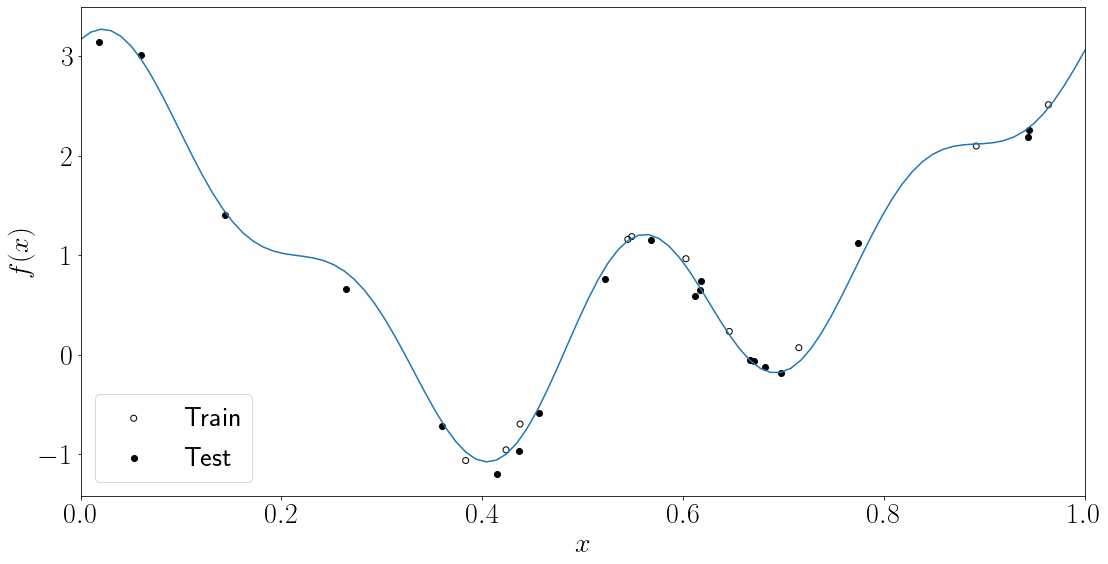

In [40]:
# Plot signals
# plot solution versus lambda
fig, ax = plt.subplots(1,1, figsize=(18, 9))
ax.scatter(x_train, y_train, marker='o', color='k', facecolors='none', label="Train")
ax.scatter(x_test, y_test, marker='o', color='k', facecolors='k', label="Test")
ax.legend()
ax.plot(x_plot, y_plot)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_xlim([0, 1]) 
plt.savefig('regularized_fitting_points.pdf')

In [36]:
# Fit a model with 5 parameters
p = 5 # Model parameters

# Define lstsq problem
A = np.column_stack([np.ones(n_train), np.sin(np.outer(x_train, w) + np.outer(np.ones(n_train), phi))])
A_test = np.column_stack([np.ones(n_test), np.sin(np.outer(x_test, w) + np.outer(np.ones(n_test), phi))])
As = [A, np.column_stack([np.zeros(p-1), np.eye(p-1)])]
bs = [y_train, np.zeros(p-1)]

# Train for different lambdas
n_lambdas = 100
lambdas = np.logspace(-6, 6, n_lambdas)
error_train = np.zeros(n_lambdas)
error_test = np.zeros(n_lambdas)
thetas = np.zeros((p, n_lambdas))

for k in range(n_lambdas):
    lam = [1, lambdas[k]]
    n = len(lam)
    theta = multi_obj_lstsq(As, bs, lam)
    error_train[k] = np.sqrt(np.sum(np.square(A @ theta - y_train))/n_train)
    error_test[k] = np.sqrt(np.sum(np.square(A_test @ theta - y_test))/n_test)
    thetas[:, k] = theta

# Compute best lambda
lam_best = lambdas[np.argmin(error_test)]

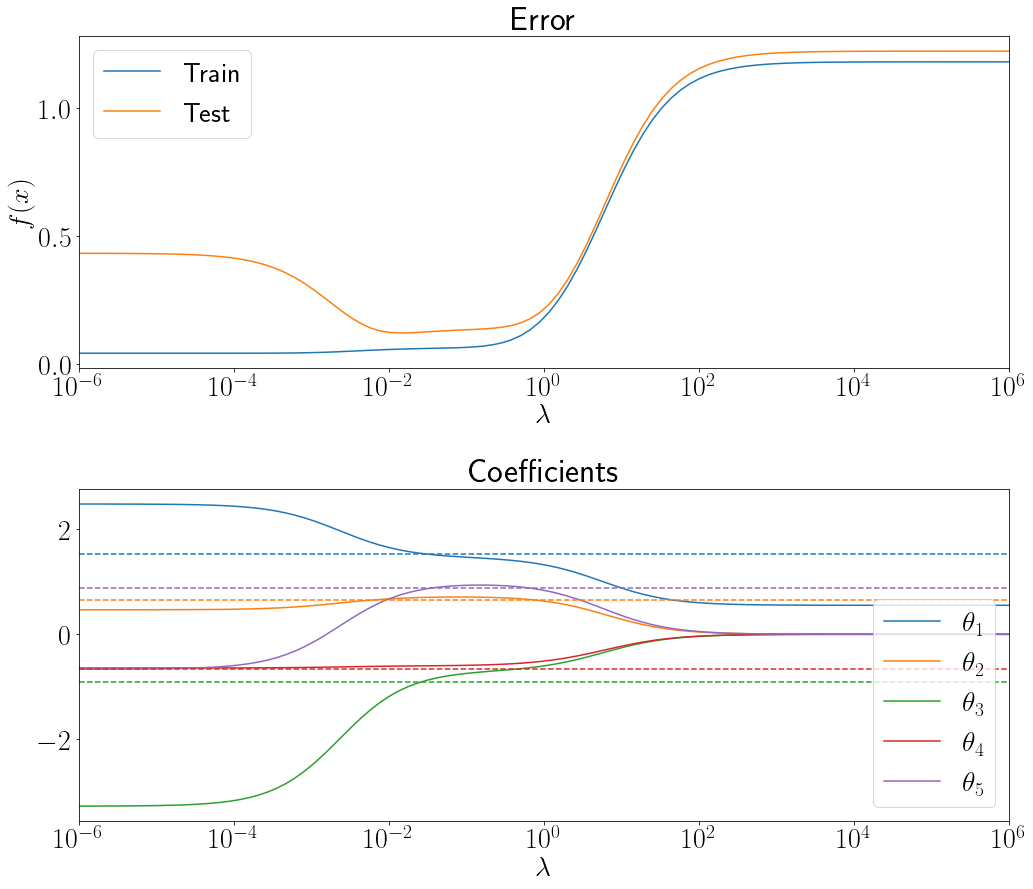

In [52]:
fig, ax = plt.subplots(2,1, figsize=(15, 13))

# Plot train vs test error
ax[0].plot(lambdas, error_train, label="Train")
ax[0].plot(lambdas, error_test, label="Test")
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$f(x)$')
ax[0].set_title('Error')
ax[0].set_xlim([lambdas[0], lambdas[-1]])

# Plot coefficients
ax[1].plot(lambdas, thetas.T)
ax[1].legend([r"$\theta_{%d}$" % (k+1) for k in range(p)], loc='lower right')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax[1].axhline(y=c, color=colors[0], linestyle='--') 
for k in range(1, 5):
    ax[1].axhline(y=alpha[k-1], color=colors[k], linestyle='--') 

ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_title('Coefficients')
ax[1].set_xlim([lambdas[0], lambdas[-1]])

plt.tight_layout()
plt.savefig("regularized_fitting_path.pdf")